This is adaptation and extension of one of the 100 recipes of the IPython Cookbook.

[IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014 (500 pages).

A good deal of material has been added to make this suitable for an introductory course.

## 8.5. Using Support Vector Machines for classification tasks

Let's do some imports.

In [5]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV as gs
import sklearn.svm as svm
import matplotlib as mpl
import matplotlib.pyplot as plt

We generate 2D points and assign a binary label according to a linear operation on the coordinates.

In [170]:
X = np.random.randn(200, 2)
y = X[:, 0] + X[:, 1] > 1

The label is True ("positive") if the sum of the two corrdinates is greater than 1; otherwise False.  This is an easy linear problem.

In [7]:
print(X.shape, X[0,0], X[0,1])
print(y[0])

(200, 2) -0.1883709634427046 -0.6495094174858415
False


The values of the coordinates for the first item X[0,:] are shown, as well as the label, computed by the rule given above,

We now fit a linear **Support Vector Classifier** (SVC). This classifier tries to find a line (a line here, more generally a hyperplane) that separates the True labels from the False labels.  Otherwise put, we train the classifier.
The output of training is a decision function that tells us how close to the line we are (close to the boundary means a low-confidence decision).  Positive decision values mean True, Negative decision values mean False.

In [8]:
est = svm.LinearSVC()
est.fit(X, y);

For visualization purposes only (specifically, to use the contour plot below), 
we manipulate the data into a "mesh grid"
shape.  We're going to plot decisions for 250000 points in a 250x250 rectangle.
To do that we'll cast the decision results in the same 250x250 meshgrid shape.

In [10]:
ll = np.zeros((500,500)) + np.linspace(-3, 3, 500)

In [13]:
np.all(ll == xx)

True

In [16]:
np.all(xx == yy.T)

True

In [9]:
# We generate a 1D point sequence x0 of 500 pts in the interval [-3,3 ] on the x-axis 
# and make xx: a 2D 500x500 grid each of whose rows is a copy of x0. 
# yy = xx.T
# The meshgrid is x0 copied 500 times through the interval  [-3,3 ] on the y-axis: total 250,000 pts
# We return the 250,000 x-coordinates and 250,000 y-coordinates
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))

# Flatten the meshgrid so the decision function can operate on the points in it
Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Put the results back in meshgrid form.
Z = Z.reshape(xx.shape)

In [6]:
print(xx.shape,Z.shape)
print('Four sample points in the grid, first row the x-ordinates, second row the y')

# In the first column of the mesh x is always -3, increases with increasing column index
print(f'{xx[0,0]: 2.3f}, {xx[1,0]: 2.3f}, {xx[0,1]: 2.3f}, {xx[1,1]: 2.3f}')
print(f'{yy[0,0]: 2.3f}, {yy[1,0]: 2.3f}, {yy[0,1]: 2.3f}, {yy[1,1]: 2.3f}')
print()
print('Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.')
print('It will have a low absolute value (near 0) for low-confidence decisions.')
print('It will change each time you run this notebook, because a new set of random points is chosen on each run.')
print()
print(f'{Z[0,0]: 2.3f}, {Z[0,1]: 2.3f}, {Z[1,0]: 2.3f}, {Z[1,1]: 2.3f}')
print()
print('The real shape of the data in table form is 250000 2 D points, a 250000x2 array')
print(np.c_[xx.ravel(),yy.ravel()].shape)

(500, 500) (500, 500)
Four sample points in the grid, first row the x-ordinates, second row the y
-3.000, -3.000, -2.988, -2.988
-3.000, -2.988, -3.000, -2.988

Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.
It will have a low absolute value (near 0) for low-confidence decisions.
It will change each time you run this notebook, because a new set of random points is chosen on each run.

-14.659, -14.633, -14.634, -14.608

The real shape of the data in table form is 250000 2 D points, a 250000x2 array
(250000, 2)


We define a function that displays the boundaries and decision function of a trained classifier.  The `scatter` function displays our points on the 2D grid we defined.  We show the regions of the grid where the decision surface `Z` has the highest values in dark blue with `imshow`, and we show the place where `Z` is 0 with the `contour` function, instructing it to draw a black line along the pointss where `z=0`.  The `scatter` function assigns a color to points as well.  Those for which the class value (`y`) is 1 are dark; those with class value 0 are light (open circles).  We draw dashed axis lies with the two `axhline` and `axvline` commands.

In [59]:
# This function takes a trained SVM estimator as input.
def plot_decision_function(est, y, confidence_plot = False, figside=6,bounds=3):
    xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                         np.linspace(-bounds, bounds, 500))
    # We evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # This works too
    #cmap = plt.cm.Reds
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    # This will color 250K pts accroding to Z-value
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # This will display the decision boundary: the boundary where Z = 0  
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='k');
    # y is a Boolean array the same size as X.shape[0], giving the class of all plotted pts
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. 
    # We boost color vals to color the true points darker.
    plt.scatter(X[:, 0], X[:, 1], s=30, c=.5+.5*y, lw=1, 
                cmap=plt.cm.Reds, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls='--');
    plt.axvline(0, color='k', ls='--');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

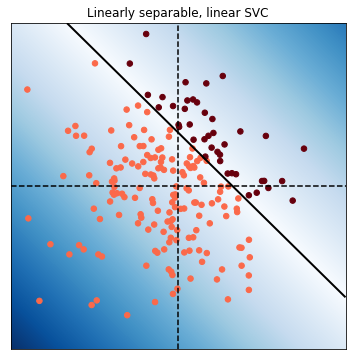

In [32]:
plot_decision_function(est, y, confidence_plot = True);
plt.title("Linearly separable, linear SVC");

The linear SVC tried to separate the points with a line and it did a pretty good job.

## A margin

Next we'll take our super-easy classification problem and make it even easier by inserting more distance between the positve and negative instances.  Let's modify our point locations
so that there is a "no man's land" between the positive and negative points.  This demonstrates that the idea of an SVM is not just drawing any linear separator but drawing the one that "maximizes" the "margin" (distance) between the separating plane and the nearest examples.

In the two cells we create a new dataset in which the Xvalues of just the positive points have been increased by 1.

In [33]:
F = np.zeros(len(y),dtype=bool)
print(F[:4])

[False False False False]


How `np.where` works:

In [34]:
a = np.arange(10)
print(a)
np.where(a < 5, a, 10*a)

[0 1 2 3 4 5 6 7 8 9]


array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [35]:
Y = np.c_[y,F]
NX = np.where(Y,X+1,X)

Line 1: We made new `Y` to use as a condition for creating new data.

Second column of Y is always `False`, first is the same as `y`.

Line 2:  Make the new X-data `NX`; leave the Y-coordinate (second column) as before.  add 1 to the corrd of the X's that were `True`.
dave the other X-values as before.

In [36]:
Y[:5]

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]])

In [37]:
print(X[:5])
print()
print(NX[:5])

[[-0.18837096 -0.64950942]
 [ 0.69652528 -1.71435648]
 [-1.40085127 -0.60329007]
 [-0.37172231 -1.22276426]
 [-1.59278736  0.20039789]]

[[-0.18837096 -0.64950942]
 [ 0.69652528 -1.71435648]
 [-1.40085127 -0.60329007]
 [-0.37172231 -1.22276426]
 [-1.59278736  0.20039789]]


The positive negative rule will be the same, the label is True ("positive") if the sum of the two ORIGINAL coordinates is greater than 1; otherwise False.  So we use the same y.

We now fit a linear **Support Vector Classifier** (SVC) to the modified data.

In [39]:
est = svm.LinearSVC(random_state=44)
est.fit(NX, y);

We now define a slightly modified function that displays the boundaries and decision function of a trained classifier, as before, and adds dashed lines to show the margin between the
separating line and the nearest data points.

In [57]:
# This function takes a SVM estimator as input.
def new_plot_decision_function(est, y, confidence_plot = False, figside=6,bounds=3):
    xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                         np.linspace(-bounds, bounds, 500))
    # We evaluate the decision function on the grid
    # flattening the grid out first
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    # put Z back into meshgrid form, for ploitting
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);            
    # We display the boundary where Z = 0
    plt.contour(xx, yy, Z, levels=[-.5,0,.5], linewidths=2,
                colors='k',negative_linestyles=['dashed'],linestyles=['dashed','solid'])
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. We color the true points darker blue.
    plt.scatter(NX[:, 0], NX[:, 1], s=30, c=0+.5*y, lw=1, 
                cmap=cmap, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls=':');
    plt.axvline(0, color='k', ls=':');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'


Text(0.5, 1.0, 'Separable with margin, linear SVC')

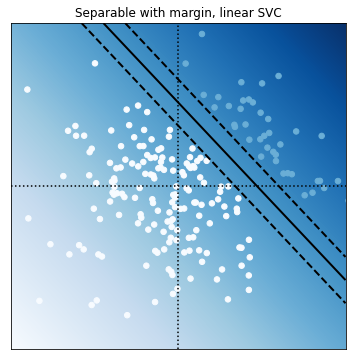

In [41]:
new_plot_decision_function(est, y)
plt.title("Separable with margin, linear SVC")

Aside:   Here's what the different linestyles mean in matplotlib.

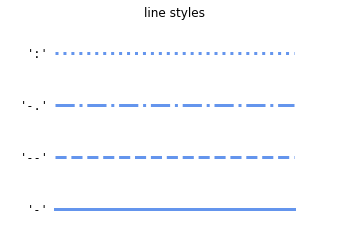

In [16]:
"""
====================
Line-style reference
====================

Reference for line-styles included with Matplotlib.
"""
import numpy as np
import matplotlib.pyplot as plt


color = 'cornflowerblue'
points = np.ones(5)  # Draw 5 points for each line
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontdict={'family': 'monospace'})


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()


def nice_repr(text):
    return repr(text).lstrip('u')


# Plot all line styles.
fig, ax = plt.subplots()

linestyles = ['-', '--', '-.', ':']
for y, linestyle in enumerate(linestyles):
    ax.text(-0.1, y, nice_repr(linestyle), **text_style)
    ax.plot(y * points, linestyle=linestyle, color=color, linewidth=3)
    format_axes(ax)
    ax.set_title('line styles')

plt.show()

## A non separable example

We now modify the labels with a *XOR* function. A point's label is 1 if the coordinates have different signs. This classification is not linearly separable. Therefore, a linear SVC fails completely.

We get lots of warnings from sklearn.  It's very upset.

/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-pac


fitting done!



/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-pac

/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/gawron/opt/anaconda3/lib/python3.7/site-pac

Score: 0.6


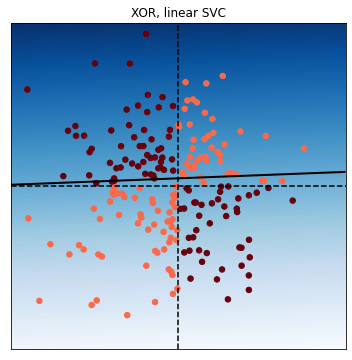

In [47]:
# the x or y coord must be positive, but not both
y2 = (X[:, 0] > 0) ^ (X[:, 1] > 0)
# We train the classifier. allow a model with some misclassified points.
est = gs(svm.LinearSVC(random_state=42), 
          {'C': np.logspace(-3., 3., 10)});
est.fit(X, y2);
print()
print('fitting done!')
print()
# We'll do cross validation on the training data, and take mean()
# cv_res is a dict
cv_res = cv(est, X, y2)
print(("Score: {0:.1f}".format(
      cv_res['test_score'].mean())))
# Plot the decision function.
plot_decision_function(est,y2);
plt.title("XOR, linear SVC");

Helpful code comment.

Line 11-13: We do cross validation on the training data and take the mean().

`cv_res` is a `dict` containing values for various efficiency & performance metrics:

In [48]:
print(cv_res.keys())
# This is cross validation on 5 different runs. Here are the 5 test scores.
print(cv_res['test_score'])
# Maybe a little better than random chance, not sure why...
print(cv_res['test_score'].mean())

dict_keys(['fit_time', 'score_time', 'test_score'])
[0.575 0.6   0.625 0.475 0.575]
0.57


Recoloring to check on its confidence ratings.  Darker region means more confidence (further from the boundary). 

Looks like the confidence is misplaced.

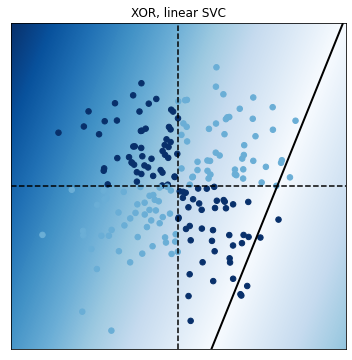

In [19]:
plot_decision_function(est,y2,confidence_plot=True);
plt.title("XOR, linear SVC");

### The kernel trick

Fortunately, it is possible to adapt a linear SVM to a non linear problem by using non-linear **kernels**. Kernels specify a non-linear transformation of the points into a higher-dimensional space. The hope is that points transformed into this space will be linearly separable, although they are not necessarily so in the original space. This trick is called the kernel trick. By default, the scikit-learn `SVC` classifier uses the **Radial Basis Function** (RBF) kernel, enabling non-linear boundaries back in the space where we're drawing our picture.

We'll try to clarify this idea below.  Right now let's just marvel at the effect.

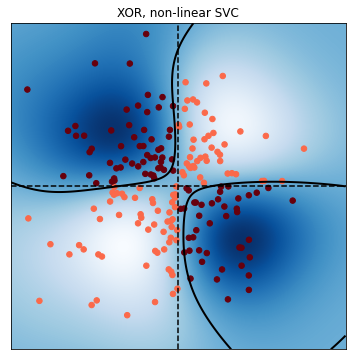

In [66]:
#clf = svm.SVC(gamma='scale').fit(X,y)
clf = svm.SVC().fit(X,y)
plot_decision_function(clf,y);
plt.title("XOR, non-linear SVC");


The kernel-aided SVC does a pretty good job at classifying these non-linearly separable points.

Notice it actually got a few points wrong and also found a non-generalizable solution.  The way the boundary in the lower right corner has been drawn, it looks like points further
from the origin than any point in training are going to be classified wrong.  

Still not bad.  The next cell does the same thing, same problem, same classifier,
but throws in a **grid_search**, because the RBF kernel has an important **hyperparameter**
`gamma` whose value may affect performance.  So let's vary the value and look for
the best performance, and while we're at it, we'll vary the value of the parameter `C`,
which allow models that misclassify a few points to be considered.

Score: 0.955


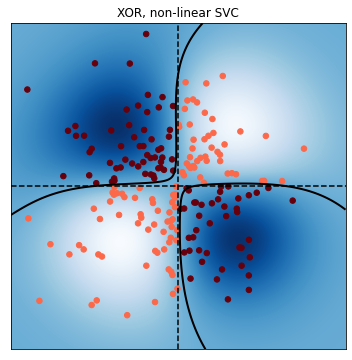

In [68]:
y = (X[:, 0] > 0) ^ (X[:, 1] > 0)
# We're going to do a grid search (gs)
# trying out 10*10 (=100) different value-settings
# for the parameter pair C and gamma to
# find the pair of values with best performance.
est = gs(svm.SVC(), 
          {'C': np.logspace(-3., 3., 10),
           'gamma': np.logspace(-3., 3., 10)});
est.fit(X, y);
##  We will also do cross validation, taking the average of 5 runs
cv_res = cv(est, X, y)
print(("Score: {0:.3f}".format(
      cv_res['test_score'].mean())))
# The est.best_estimator_ uses teh parameters that did best in the grid search
plot_decision_function(est.best_estimator_,y);
plt.title("XOR, non-linear SVC");

This is better.

Let's try to get an idea of how this works.

## A simple example of hand-rolled higher dimensionality

The general idea of which kernels are a special (mathematically appealing) case is this: what if we could transform this data into a higher-dimensional (3D) space where the data is separable by a linear classifier?

We can illustrate quite simple with the XOR example.  Let's add a third dimension to the data, and the value of that third dimension will be given by:

```
z = xy
```

Take the product of the x and y coordinates as the z coordinate.  SVMs don't care about
how many dimensions the data has, so that won't affect the SVM.

Note this new coordinate is a non linear function of the the first two.  But that has no effect on whether the new points in 3D space won't be linearly separable.

We demonstrate.

In [172]:
#Add a new column to X containing the product of the first two
X = np.random.randn(200, 2)
newX = np.concatenate([X,X[:,0:1]*X[:,1:2]],axis=1)
## Before and after samples
print('Before')
print(X[5:7,:])
print('After')
print(newX[5:7])
newX.shape

Before
[[ 0.05401892 -0.84102253]
 [ 1.76983383  1.58777976]]
After
[[ 0.05401892 -0.84102253 -0.04543113]
 [ 1.76983383  1.58777976  2.81010634]]


(200, 3)

In the next cell, we train on the new data with the same classification rule as before.

Bingo! Instant success:

In [173]:
# Same rule as before
y = (newX[:, 0] > 0) ^ (newX[:, 1] > 0)
# We're going to do a grid search (gs)
# trying out 10*10 (=100) different value-settings
# for the parameter pair C and gamma to
# find the pair of values with best performance.
est = svm.LinearSVC(random_state=42)
est.fit(newX, y);
##  We will also do cross validation, taking the average of 5 runs
cv_res = cv(est, newX, y)
print(("Score: {0:.3f}".format(
      cv_res['test_score'].mean())))
# The est.best_estimator_ uses teh parameters that did best in the grid search
#plot_decision_function(est.best_estimator_,y);
#plt.title("XOR, non-linear SVC");

Score: 0.955


To see why this works, we plot our new points in 3D space.  


Redoing things to set up 3D plotting:

In [175]:
def f(x, y):
    return x*y

def f2(x,y):
    # This function is everywhere 0
    # Also Return an array of the right shape 
    return np.zeros(X.shape)

x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
Z2 = f2(X,Y)

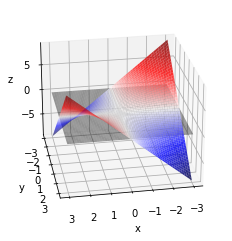

In [179]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,
             cmap='seismic', edgecolor='none',alpha=.8)
#Default vals
#ax.elev 30; ax.azim -60
elev,azim = 25, 80
ax.view_init(elev,azim)
#print('ax.azim {}'.format(ax.azim))
#print('ax.elev {}'.format(ax.elev))
ax.plot_surface(X, Y, Z2, rstride=10, cstride=10,
               cmap='Greys_r', edgecolor='none',alpha=.4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


In a 3D problem, a linear classifier is looking for a plane rather
than a line, because a plane **separates** 3D space into two regions.
In our problem, the SVM classifier needs to find a plane 
that separates the XOR points from the non-XOR points.
Now Z is positive when the signs of X and Y are the same, and
negative when they differ; so the points where Z is negative 
(the blue points below the XY plane)
are precisely the points for which the XOR property is True. 
In other words, with our data represented this way,
the XY plane (shown in light gray) is precisely the linear separator we're
looking for.

During training, the SVM found that plane or something very close to
it, and successfully separated the data.

Strategically what we're looking for  in that third dimension is a surface that gets negative at just
the right places to simulate XOR.  It wouldn't hurt if it was smooth too. The function f = xy fits the
bill perfectly.

So this is how the extra dimensionality helps.  We use the extra dimensions to
fit in information about the relationship and x and y.  If we can hit on the right
relationship.

But back in the original space, the separation we're drawing is not linear!

We demonstrate below by displaying the
a contour map of Z in the XY plane, with the dark lines showing where Z is 0.
The dark lines are of course the X and Y axis.

The colors in the 3D plot have simply been projected onto the XY plane.
Blue means positive Z (points with the XOR property); red means negative
(don't have the XOR property). So the X and Y axis really do constitute the separator between
having the XOR property and not having it. The negative points
in the 1st and 3rd quadrants fall on one "side" of the separator,
which is definitely not a line.

So we have a separator that is definitely **not** linear drawn by a classifier that
definitely is.  And that is the essence of the kernel trick.

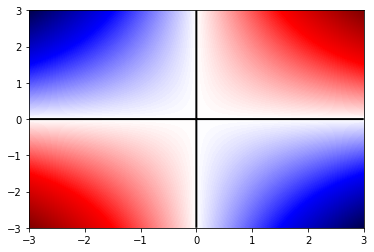

In [160]:
fig = plt.figure()
ax = plt.axes()
toshow = Z
cmap = plt.cm.seismic
# Show where abs(Z) is 0, where Z goes pos to neg.
plt.imshow(toshow,
           extent=(X.min(), X.max(), Y.min(), Y.max()),
          aspect='auto', origin='lower', cmap=cmap);
plt.contour(X, Y, Z, levels=[0], linewidths=2,
                colors='k')

A final note.  The use of higher dimension models to achieve non linear separation with linear models has come up before.

This is what a polynomial regression model does.  Polynomial regression was discussed in the simple regression notebook. Given a dataset of n-dimensions, polynomial models create an expanded dataset of n+m dimsensions, where each of the new dimensions is a simple polynomial function of the original n-dimensions.  The resulting modeling problem is still linear: Find the linear combination of the n+m dimensions that does the best job of predicting.

More generally, transforming the data in various ways can give rise to both more powerful and more principled models while still leaving us with is essentially a linear model.  As the XOR example shows, propblems that could not be solved in the original data space can be solved in the transformed space. Moreover, the transformation does not need to be one that increases the dimensionality of the data.  Logistic regressors and logistic classifiers fall in this category.  The class of linear models opened up by such strategies are call **generalized linear models**.

One of the reasons scikit learn is such an incredibly useful and popular toolkit is that provides access to a very rich variety of generalized linear models through a consistent and easy to use interface.  SVMs (Support Vector Machines) boosted with kernels are one important example.  And that's what we've taken advatage of in this
notebook.